# Social dimension (Who)
* Misinformation detection exploiting user features
* Detection of malicious users: can we distinguish malicious from gullible users?
* Detection of superspreaders: abnormal rates of misinformation spread
* Detection of sources of misinformation: first users to share misinformation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec

%matplotlib inline
sns.set(style="darkgrid")

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load data users data

In [2]:
# users
df_users = pd.read_csv('data/2018/users.csv')

# credibility score with laplace smoothing

df_users['credibility'] = 1-df_users['misinformation']/(df_users['virals']+1)
df_users = df_users.rename(columns={"misinformation": "misinformations"})
print(df_users.columns)
df_users

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'repeated_messages',
       'repeated_messages_ratio', 'days_active', 'daily_mean', 'daily_std',
       'daily_median', 'daily_95', 'daily_outliers', 'daily_max',
       'degree_centrality', 'strenght', 'viral_degree_centrality',
       'viral_strenght', 'misinformations', 'misinformation_degree_centrality',
       'misinformation_strenght', 'misinformation_ratio',
       'viral_misinformation_ratio', 'credibility'],
      dtype='object')


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,22,0.005005,609,...,153,672588,153,3366,10,153,1530,0.002275,0.454545,0.565217
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,223,0.095626,363,...,1710,498161,1631,47054,58,1506,11907,0.024871,0.260090,0.741071
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,227,0.109981,94,...,534,391490,534,43406,85,534,15800,0.041182,0.374449,0.627193
3,2839535797075678550,5,2020,1587,0.785644,433,0.214356,104,0.051485,258,...,895,644390,895,26260,25,866,6179,0.012376,0.240385,0.761905
4,170916900626840870,1,1810,828,0.457459,982,0.542541,96,0.053039,24,...,153,276930,153,14688,69,153,10557,0.038122,0.718750,0.288660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,-3685511676029813622,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,166,166,0,0,0,0,0,0.000000,0.000000,1.000000
5360,-3687281691650946329,1,1,0,0.000000,1,1.000000,0,0.000000,0,...,188,188,0,0,0,0,0,0.000000,0.000000,1.000000
5361,4870300454101875011,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,57,57,0,0,0,0,0,0.000000,0.000000,1.000000
5362,7020988212245908273,1,1,1,1.000000,0,0.000000,0,0.000000,0,...,91,91,0,0,0,0,0,0.000000,0.000000,1.000000


# Associate misinformation with information of the first user that shared

In [3]:

# dataset with labelled data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')

# select only labelled data
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['midia']==0]
df = df[df['misinformation']!=-1]

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)
df = df[['id','text','misinformation', 'timestamp']]

df_full = df.copy()
df.drop_duplicates(subset='text', inplace = True)

df['label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
print(len(df))
df.reset_index(drop=True,inplace=True)
df.head()

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


6926


,id,text,misinformation,timestamp,label
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation


## Get mean features from all users who shared the message

In [4]:
m = df['text'][2]
k = 1
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame()

users = df_full[df_full['text']==m].sort_values(by='timestamp')
users = list((users['id']))
print(users)

df_users_shared_line = pd.DataFrame()
for i in range(k): # u in users
    try:
        u = users[i]        
        line = df_users[df_users['id']==u][user_features].reset_index(drop=True)
    except:
        line = pd.DataFrame(np.zeros((1, len(user_features))), columns = user_features)
    
    df_users_shared_line = pd.concat([df_users_shared_line, line], axis = 1)


df_users_shared_line

[-5100443702615645928, -5100443702615645928]


,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,repeated_messages,repeated_messages_ratio,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,1,340,266,0.782353,74,0.217647,63,0.185294,6,0.022556,...,270,91800,270,17010,47,270,12690,0.138235,0.746032,0.265625


In [5]:
k = 1
user_features = df_users.columns[1:]
df_user_features = pd.DataFrame()

for m in df['text']:
    users = df_full[df_full['text']==m].sort_values(by='timestamp')
    users = list((users['id']))

    df_users_shared_line = pd.DataFrame()
    for i in range(k): # u in users
        try:
            u = users[i]        
            line = df_users[df_users['id']==u][user_features].reset_index(drop=True)
        except:
            line = pd.DataFrame(np.zeros((1, len(user_features))), columns = user_features)

        df_users_shared_line = pd.concat([df_users_shared_line, line], axis = 1)
    
    df_user_features = pd.concat([df_user_features, df_users_shared_line])

df_user_features = df_user_features.reset_index(drop=True)
df = pd.concat([df,df_user_features], axis = 1)

In [6]:
df

,id,text,misinformation,timestamp,label,groups,number_of_messages,texts,text_ratio,midia,...,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformations,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,credibility
0,6942577183305588053,"O dia em que ex-guerrilheiro, militantes e des...",1,2018-07-02 10:46:00,misinformation,1,31,4,0.129032,27,...,44,1364,0,0,1,44,44,0.032258,0.000000,0.000000
1,-2072140886659020977,O nível dos jornalistas do programa Roda Viva ...,1,2018-07-02 10:50:00,misinformation,3,2064,948,0.459302,1116,...,534,391490,534,43406,85,534,15800,0.041182,0.374449,0.627193
2,-5100443702615645928,*Atenção*\n\nPrecisamos da ajuda de todos você...,0,2018-07-02 11:03:00,non-misinformation,1,340,266,0.782353,74,...,270,91800,270,17010,47,270,12690,0.138235,0.746032,0.265625
3,-1561843698204261697,"Gestão do colombiano na capital, imagina ele n...",1,2018-07-02 16:31:00,misinformation,6,78,50,0.641026,28,...,739,13472,710,5476,12,739,1843,0.153846,0.400000,0.612903
4,-5876784761398352499,🛑🛑🛑🛑🛑🛑\nInterrompendo momentaneamente a conver...,1,2018-07-02 18:09:00,misinformation,2,63,35,0.555556,28,...,122,3831,122,667,4,122,244,0.063492,0.363636,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6921,9168025156996167745,EM GRATIDÃO... PEDIMOS AO POVO BRASILEIRO QUE ...,0,2018-10-28 18:53:00,non-misinformation,1,31,12,0.387097,19,...,326,10106,326,652,0,0,0,0.000000,0.000000,1.000000
6922,-5542692723449689572,Que Deus ilumine o novo presidente. É um alívi...,0,2018-10-28 19:24:00,non-misinformation,1,42,24,0.571429,18,...,89,3738,89,890,4,89,356,0.095238,0.400000,0.636364
6923,-6076734346383138898,Contra TD e contra todos... Mostramos q o Bras...,0,2018-10-28 19:27:00,non-misinformation,1,14,11,0.785714,3,...,306,4284,306,306,0,0,0,0.000000,0.000000,1.000000
6924,2485357201479715834,OLHA O QUANTO AVANÇAMOS! SE LIGA NESSA LIMPEZA...,1,2018-10-28 21:53:00,misinformation,1,327,81,0.247706,246,...,95,31065,95,1900,12,95,1140,0.036697,0.600000,0.428571


## Feature engineering

In [7]:
df.columns

Index(['id', 'text', 'misinformation', 'timestamp', 'label', 'groups',
       'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_std', 'daily_median', 'daily_95',
       'daily_outliers', 'daily_max', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformations',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'credibility'],
      dtype='object')

In [8]:
user_features = ['groups', 'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio',
       'virals', 'viral_ratio', 'repeated_messages', 'repeated_messages_ratio',
       'days_active', 'daily_mean', 'daily_median', 'daily_max',
       'daily_outliers', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght']
X = df[user_features]
y = df['misinformation']
X.shape

(6926, 19)

[0.00918092 0.04483158 0.05637226 0.05653816 0.0448243  0.09084497
 0.01852555 0.08751904 0.01365361 0.10923408 0.08496837 0.09105831
 0.01813323 0.04936835 0.02528964 0.04040267 0.06818648 0.02492879
 0.06613971]


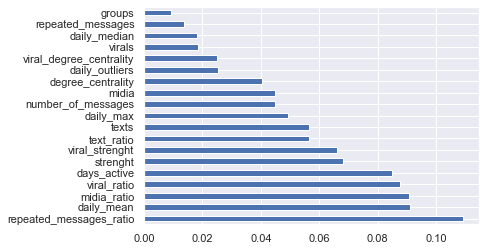

In [11]:
# feature importance
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [30]:
user_classification_features = list(feat_importances.nlargest(10).index)
user_classification_features

['repeated_messages_ratio',
 'daily_mean',
 'midia_ratio',
 'viral_ratio',
 'days_active',
 'strenght',
 'viral_strenght',
 'text_ratio',
 'texts',
 'daily_max']

# Exploiting user information to detect misinformation

In [15]:
# messages
df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')

In [16]:
# df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]
# df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]
# df_train.to_csv('data/2018/train-test/train.csv', index = False)
# df_test.to_csv('data/2018/train-test/test.csv', index = False)

In [17]:
# user_classification_features = ['groups', 'number_of_messages', 'midia_ratio',
#        'viral_ratio', , 'degree_centrality', 'strenght',
#        'viral_degree_centrality', 'viral_strenght']

#user_classification_features = ['midia_ratio', 'viral_ratio', 'repeated_messages_ratio']

def acquire_user_info(df_target, df_origin):   

    
    df_user_features = pd.DataFrame()
    

    for m in df_target['text']:
        user_info = df_origin[df_origin['text']==m]
        user_info.sort_values(by='timestamp')        
        user_info = user_info[0:1]        
        user_info = user_info[user_classification_features]
        df_user_features = pd.concat([df_user_features, user_info])
        
    df_user_features.reset_index(drop= True, inplace = True)
    df_target = pd.concat([df_target, df_user_features], axis = 1)
    return df_target

df_train = acquire_user_info(df_train, df)
df_test = acquire_user_info(df_test, df)    

In [18]:
df_train.head()

,text,misinformation,original,id_message,preprocessed_text,repeated_messages_ratio,daily_mean,midia_ratio,viral_ratio,days_active,strenght,viral_strenght,text_ratio,texts,daily_max
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...,0.032258,1.205128,0.560284,0.127660,117,8037,1026,0.439716,62,16
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...,0.412993,9.128205,0.394663,0.394663,78,150659,58028,0.605337,431,43
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...,0.030769,13.857143,0.731959,0.125773,35,44135,5551,0.268041,130,73
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.102190,4.878378,0.620499,0.058172,74,97470,5670,0.379501,137,62
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...,0.025641,1.737288,0.619512,0.156098,118,30340,4736,0.380488,78,26


In [19]:
# include viral strenght
# X_train = df_train[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# X_test = df_test[['midia_ratio','viral_ratio', 'viral_strenght']].to_numpy()
# y_train = df_train['misinformation']
# y_test = df_test['misinformation']
# X_train,X_test = utils.z_score(X_train,X_test)
# X_train.shape


X_train = df_train[user_classification_features].to_numpy()
X_train = np.array(X_train, dtype=np.float64)
X_test = df_test[user_classification_features].to_numpy()
X_test = np.array(X_test, dtype=np.float64)
y_train = df_train['misinformation']
y_test = df_test['misinformation']

X_train_u, X_test_u = utils.z_score(X_train, X_test)
X_train, X_test = utils.z_score(X_train, X_test)

print('train', X_train.shape)
print('test', X_test.shape)

# with open('train_user_features.npy', 'wb') as f:
#     np.save(f, X_train)
    
# with open('test_user_features.npy', 'wb') as f:
#     np.save(f, X_test)

train (6233, 10)
test (1574, 10)


logistic regression + user info
0.51
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       834
           1       0.54      0.47      0.50       740

    accuracy                           0.56      1574
   macro avg       0.56      0.56      0.55      1574
weighted avg       0.56      0.56      0.56      1574

AUC:  0.6045045045045044


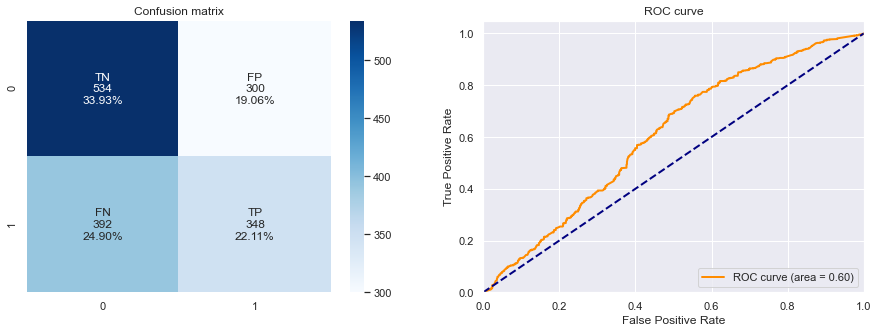

0,560
0,393
0,537
0,470
0,501
0,604


(0.5603557814485387,
 0.3931818181818182,
 0.5370370370370371,
 0.4702702702702703,
 0.5014409221902019,
 0.6045045045045044)

In [20]:
print('logistic regression + user info')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.572
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.582
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.577
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.587
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.575

--------------------
BEST PARAMETERS (validation AUC = 0.587)
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
--------------------
0.5
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       834
           1       0.55      0.62      0.58       740

    accuracy                           0.59      1574
   macro avg       0.59      0.59      0.59      1574
weighted avg       0.59      0.59      0.59      1574

AUC:  0.6215195411238577


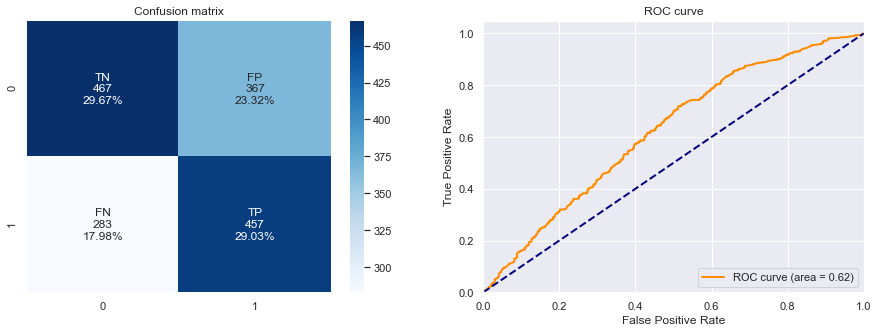

0,587
0,410
0,554
0,617
0,584
0,621


(0.5870393900889453,
 0.41035353535353525,
 0.5546116504854369,
 0.6175675675675676,
 0.5843989769820972,
 0.6215195411238577)

In [21]:
print('mlp + user')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Combining with text

## User + Word2Vec

In [22]:
w2v = Word2Vec.load("data/2018/word2vec.model")
X_train_w = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test_w = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])

In [23]:
X_train = np.concatenate((X_train_w, X_train_u), axis=1)
X_test = np.concatenate((X_test_w, X_test_u), axis=1)

logistic regression + user info + w2v
0.46
              precision    recall  f1-score   support

           0       0.77      0.70      0.74       834
           1       0.70      0.77      0.73       740

    accuracy                           0.73      1574
   macro avg       0.74      0.74      0.73      1574
weighted avg       0.74      0.73      0.73      1574

AUC:  0.8074534966621298


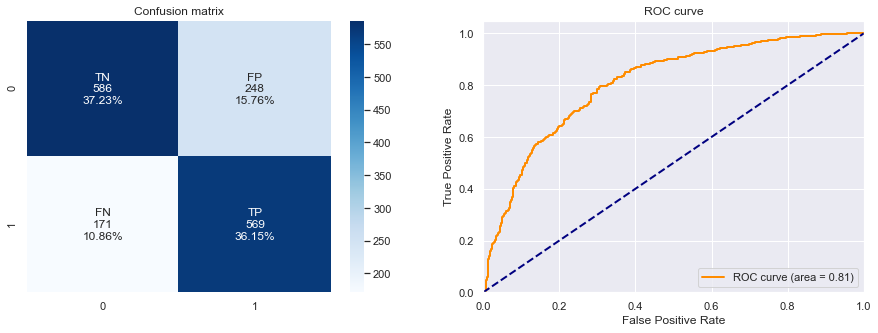

0,733
0,263
0,696
0,768
0,730
0,807


(0.7337992376111817,
 0.26335637963544944,
 0.6964504283965728,
 0.768918918918919,
 0.730892742453436,
 0.8074534966621298)

In [24]:
print('logistic regression + user info + w2v')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.744
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.694
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.819
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.798
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.761
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.795
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.816
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.806
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.857
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.830

--------------------
BEST PARAMETERS (validation AUC = 0.857)
h

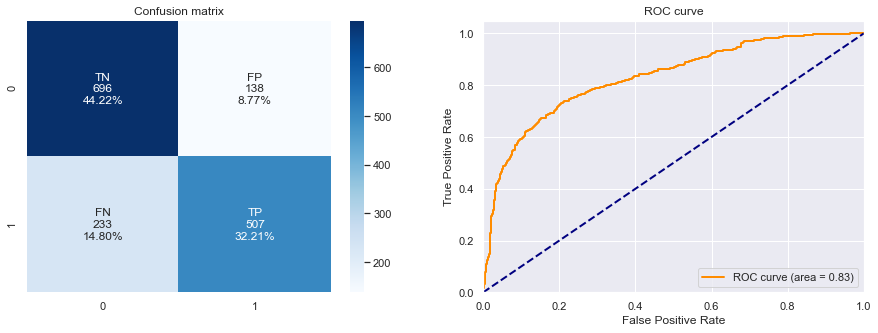

0,764
0,210
0,786
0,685
0,732
0,830


(0.764294790343075,
 0.2104367555303459,
 0.786046511627907,
 0.6851351351351351,
 0.7321299638989169,
 0.8300213882947696)

In [25]:
print('mlp + user + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

## TF-IDF + users

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,1), #(1,3)  #15000
                             lowercase = False, token_pattern = r'[^\s]+', binary=False)

tfidf.fit(df_train['preprocessed_text'])   
X_train_tfidf = tfidf.transform(df_train['preprocessed_text']).todense()
X_test_tfidf = tfidf.transform(df_test['preprocessed_text']).todense()
X_train_tfidf.shape

(6233, 17525)

In [27]:
X_train = np.concatenate((X_train_tfidf, X_train_u), axis=1)
X_test = np.concatenate((X_test_tfidf, X_test_u), axis=1)

logistic regression + user info + tfidf
0.47
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       834
           1       0.78      0.80      0.79       740

    accuracy                           0.80      1574
   macro avg       0.80      0.80      0.80      1574
weighted avg       0.80      0.80      0.80      1574

AUC:  0.8653687860522393


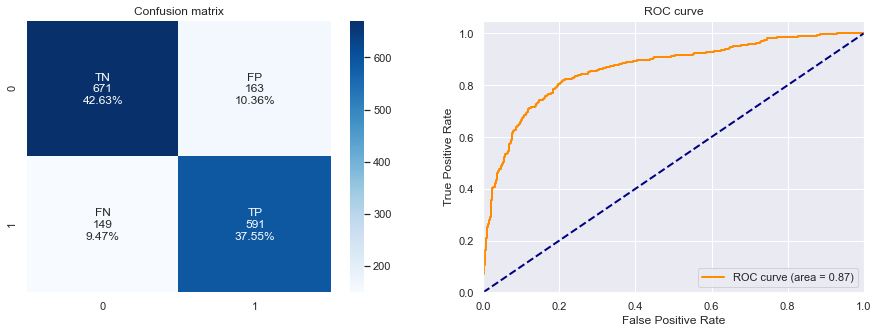

0,801
0,188
0,783
0,798
0,791
0,865


(0.8017789072426937,
 0.18863361547763002,
 0.7838196286472149,
 0.7986486486486486,
 0.7911646586345381,
 0.8653687860522393)

In [28]:
print('logistic regression + user info + tfidf')
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + user + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.856
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.870
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.880
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.873
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.873
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.861
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.880
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.875
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.875
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.880

--------------------
BEST PARAMETERS (validation AUC = 0.880)

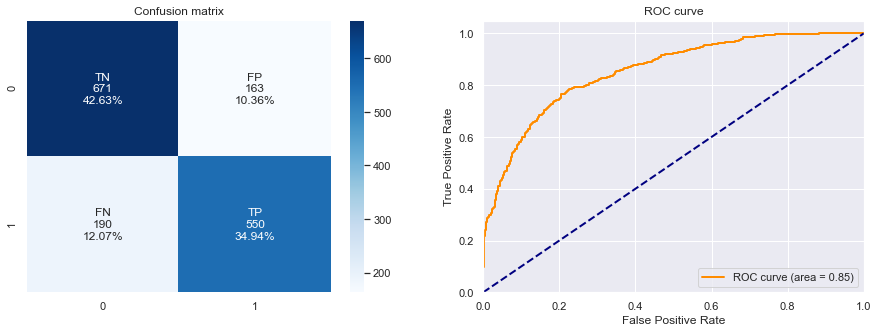

0,775
0,208
0,771
0,743
0,757
0,854


(0.7757306226175349,
 0.20825958702064895,
 0.7713884992987378,
 0.7432432432432432,
 0.7570543702684103,
 0.8543700174995139)

In [29]:
print('mlp + user + tfidf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)